# **Ф36**: Модуль генерации ценностно-ориентированных требований к трансформации территорий

## 1. Читаем подготовленные данные

In [14]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types_df = pd.read_pickle('./data/service_types.pickle')
blocks_gdf = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')
dist_mx = pd.read_pickle('./data/dist_mx.pickle')

Берем лишь те типы сервисов, где известны ценности, которые они поддерживают

In [15]:
service_types_df = service_types_df[~service_types_df['soc_values_ids'].isna()].copy()

In [16]:
service_types_df

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet
service_type_id,,,,,,,,,
1,2000.0,basic,0.20,None,30.0,NaN,150.0,"[8, 18, 1]",park
4,NaN,None,NaN,NaN,NaN,NaN,NaN,[18],None
21,500.0,basic,0.20,None,7.0,NaN,61.0,[2],kindergarten
22,800.0,basic,0.20,None,15.0,NaN,120.0,"[2, 4, 1]",school
26,5000.0,None,NaN,NaN,NaN,NaN,NaN,"[4, 10, 17]",college
27,5000.0,comfort,0.20,None,60.0,NaN,13.0,"[4, 10, 17]",university
28,NaN,basic,0.20,None,10.0,NaN,13.0,"[15, 1]",polyclinic
30,1000.0,additional,0.30,NaN,NaN,NaN,NaN,[15],None
32,NaN,None,NaN,NaN,NaN,NaN,NaN,[2],None


## 2. Вспомогательный код

Тут надо научиться просто грамотно вылавливать деманд и доступность для `service_type_id`

In [17]:
from blocksnet.analysis.provision import competitive_provision, provision_strong_total
from blocksnet.relations.accessibility import get_accessibility_context
from blocksnet.config import service_types_config

def _get_project_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=False)
  return list(context_blocks.index)

def _choose_accessibility(service_type_row : pd.Series, acc_mx : pd.DataFrame, dist_mx : pd.DataFrame) -> tuple[int, pd.DataFrame]:
    time = service_type_row['time_availability_minutes']
    radius = service_type_row['radius_availability_meters']
    if pd.notna(time):
        return int(time), acc_mx
    if pd.notna(radius):
        return int(radius), dist_mx
    
    name = service_type_row['blocksnet']
    if pd.notna(name):
        _, _, accessibility = service_types_config[name].values()
        return accessibility, acc_mx
    
    return None, None

def _choose_demand(service_type_row : pd.Series, blocks_df : pd.DataFrame) -> tuple[int, pd.DataFrame]:
    service_type_id = service_type_row.name
    count_per = service_type_row['services_per_1000_normative']        
    capacity_per = service_type_row['services_capacity_per_1000_normative']

    if pd.notna(count_per): # умножаем на 100 для придания большей точности, потому что задача целочисленная
        df = blocks_df.rename(columns={
            f'count_{service_type_id}': 'capacity',
        })[['population', 'capacity']].fillna(0)
        df['capacity'] *= 100
        return int(count_per) * 100, df
    
    if pd.notna(capacity_per):
        df = blocks_df.rename(columns={
            f'capacity_{service_type_id}': 'capacity',
        })[['population', 'capacity']].fillna(0)
        return int(capacity_per), df
    
    name = service_type_row['blocksnet']
    if pd.notna(name):
        _, demand, _ = service_types_config[name].values()
        df = blocks_df.rename(columns={
            f'capacity_{service_type_id}': 'capacity',
        })[['population', 'capacity']].fillna(0)
        return demand, df
    
    return None, None
    
def assess_provision(
        blocks_gdf : gpd.GeoDataFrame, 
        acc_mx : pd.DataFrame, 
        dist_mx : pd.DataFrame, 
        service_type_row : pd.Series
    ) -> tuple[float, gpd.GeoDataFrame]:
    
    # в зависимости от норматива будем по-разному считать чиселки и готовить датафреймы
    accessibility, mx = _choose_accessibility(service_type_row, acc_mx, dist_mx)
    demand, df = _choose_demand(service_type_row, blocks_gdf)

    if demand is None or accessibility is None: # если не умеем считать, скип
        return None, None
    
    # зануляем проект
    df = df.copy()
    df.loc[blocks_gdf['is_project'], df.columns] = 0 # зануляем все в проекте
    
    # отбираем контекст
    context_ids = _get_project_context(blocks_gdf, mx, accessibility)

    # считаем оценки
    prov_df, _ = competitive_provision(df, mx, accessibility, demand)
    prov_df = prov_df.loc[context_ids].copy()

    provision_total = provision_strong_total(prov_df)
    
    gdf = blocks_gdf.loc[context_ids, ['geometry']].join(prov_df)
    return provision_total, gdf

## 3. Оценка

0. Обнуляем сервисы и здания в границах проекта.
1. Считаем обеспеченности по каждому типу сервиса (если столбца нет, то у нас и типа сервиса нет по идее вокруг и на территории).
2. Обрезаем до уровня контекста.
3. Считаем суммарную оценку по контексту кварталов и ассоциируем её с ценностью.

P.S: под контекстом в данном случае понимаем не контекст в рамках Простора, а контекст в рамках доступности квартала.

In [18]:
from tqdm import tqdm

soc_values_provisions = {}
provisions_gdfs = {}

for st_id, st_row in tqdm(service_types_df.iterrows()):
  soc_values_ids = service_types_df.loc[st_id,'soc_values_ids']
  prov_total, prov_gdf = assess_provision(blocks_gdf, acc_mx, dist_mx, st_row)

  provisions_gdfs[st_id] = prov_gdf
  for soc_value_id in soc_values_ids:
    if soc_value_id in soc_values_provisions:
      soc_values_provisions[soc_value_id].append(prov_total)
    else:
      soc_values_provisions[soc_value_id] = [prov_total]

59it [00:02, 27.16it/s]


In [19]:
soc_values_provisions

{8: [0.9904610492845787, 0.0, 1.0, 0.0, 0.0],
 18: [0.9904610492845787, None],
 1: [0.9904610492845787, 0.0, 0.0, 0.0],
 2: [0.0, 0.0, None, None, 0.0],
 4: [0.0, 1.0, 0.0, None],
 10: [1.0, 0.0],
 17: [1.0, 0.0, 0.0, 0.98989898989899],
 15: [0.0, None, 0.0, 0.0, None, None, 1.0],
 16: [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.21733858745074264,
  0.0,
  0.1024552894816611,
  0.0,
  0.03031221582297666,
  0.0,
  0.0,
  0.0],
 11: [0.9666666666666667, 0.0, 1.0],
 3: [0.0, None],
 7: [0.0, 0.0, 0.9827586206896551, 0.0, 0.0, None],
 14: [0.0, None, 0.0, 0.0],
 5: [0.15151515151515152, 0.0, 0.0, 0.0],
 6: [1.0, 0.0, 0.0, 0.0],
 13: [0.0, None, 0.0],
 9: [0.0]}

## 2. Результат

`soc_value_id` -> уровень поддержки ценности

In [20]:
import numpy as np

def _get_value_level(provisions : list[float | None]) -> float:
  provisions = [p for p in provisions if p is not None]
  return np.mean(provisions)

index = soc_values_provisions.keys()
columns = ['social_value_level']
result_df = pd.DataFrame(data=[_get_value_level(soc_values_provisions[sv_id]) for sv_id in index], index=index, columns=columns)
result_df

,social_value_level
8,0.398092
18,0.990461
1,0.247615
2,0.000000
4,0.333333
10,0.500000
17,0.497475
15,0.250000
16,0.096436
11,0.655556


Слои с оценкой обеспеченности в границах контекста

/home/vasilstar/prostor-examples/.venv/lib/python3.10/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


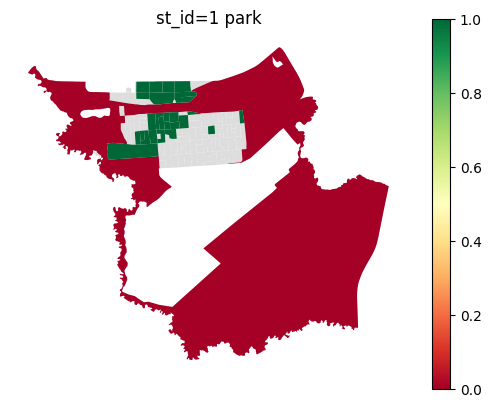

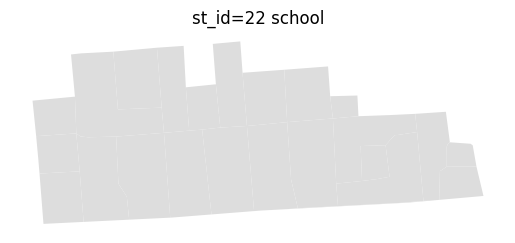

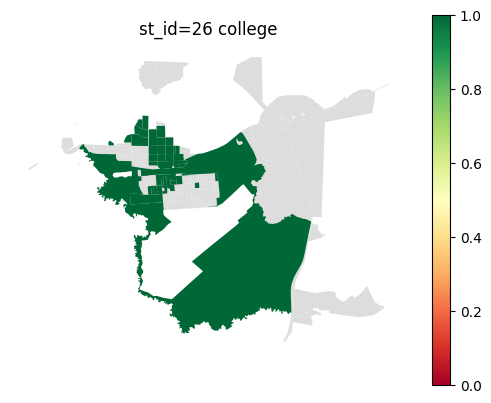

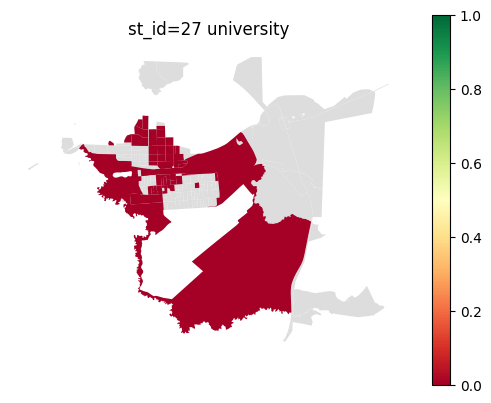

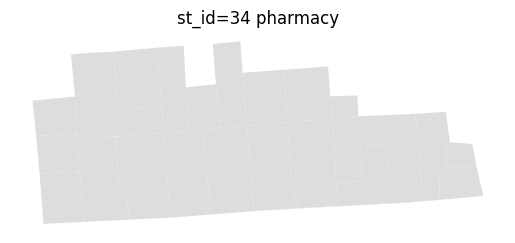

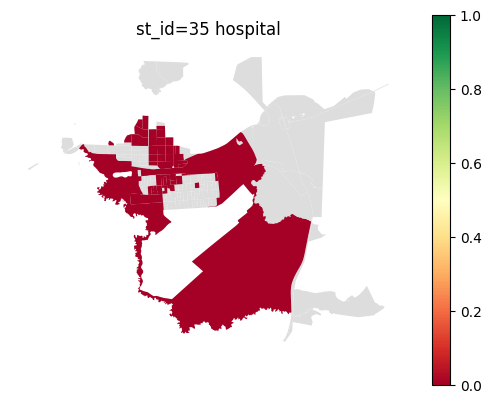

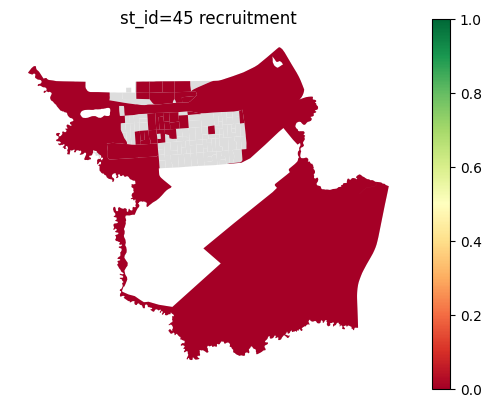

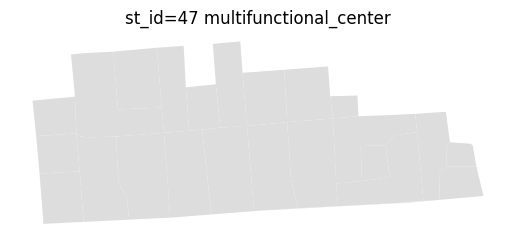

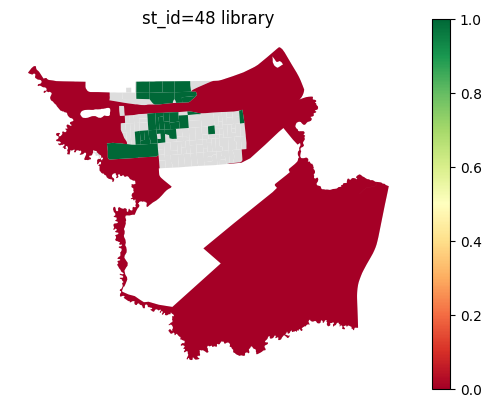

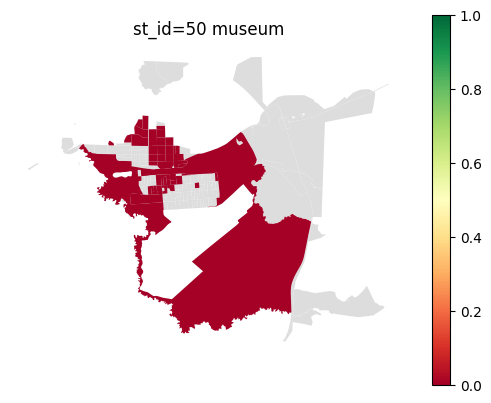

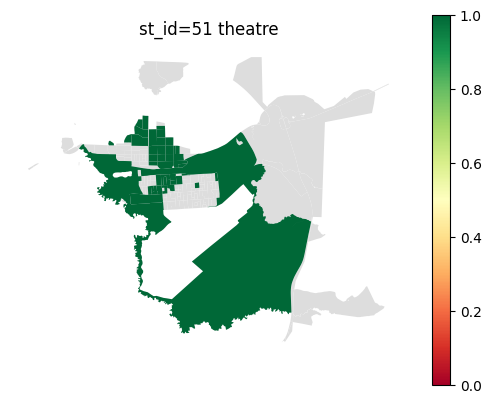

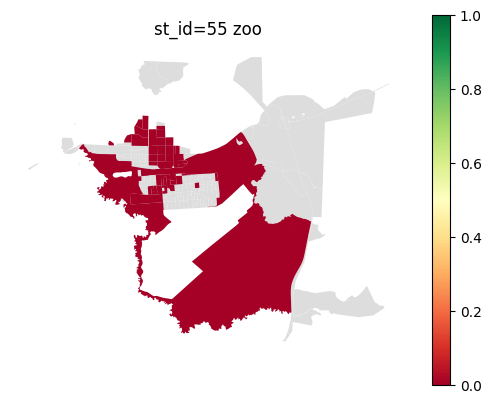

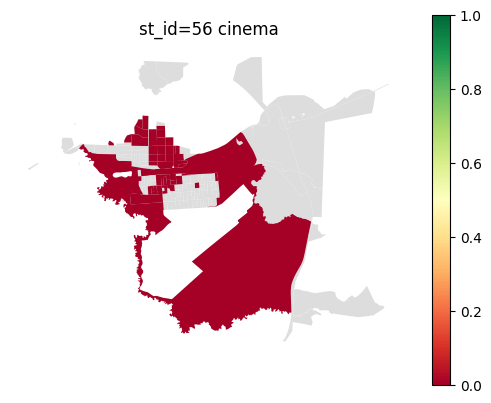

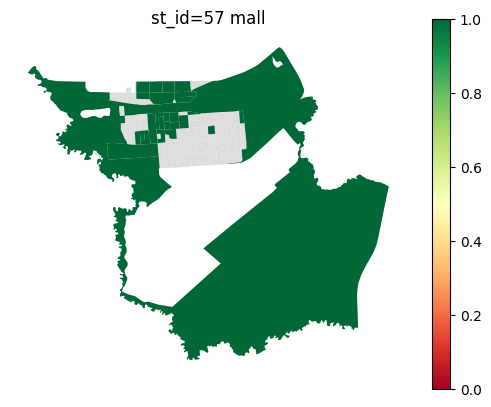

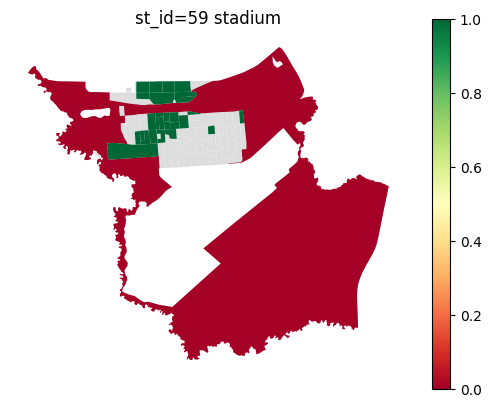

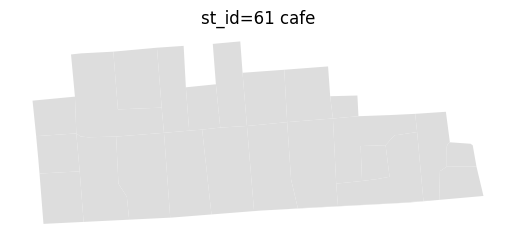

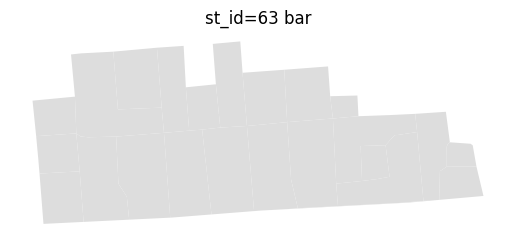

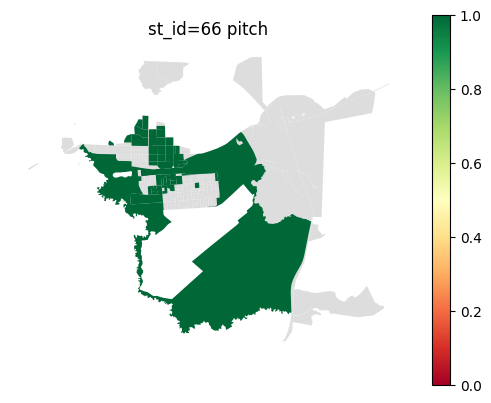

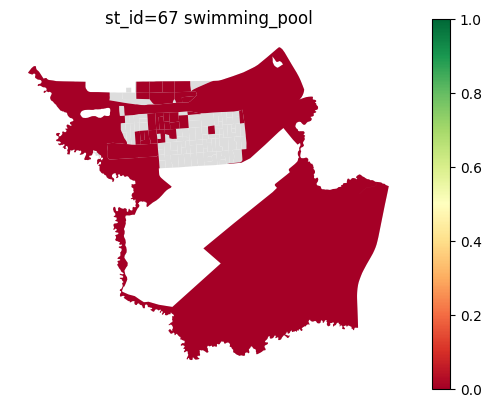

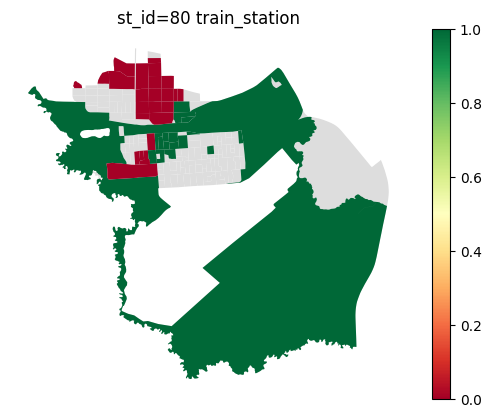

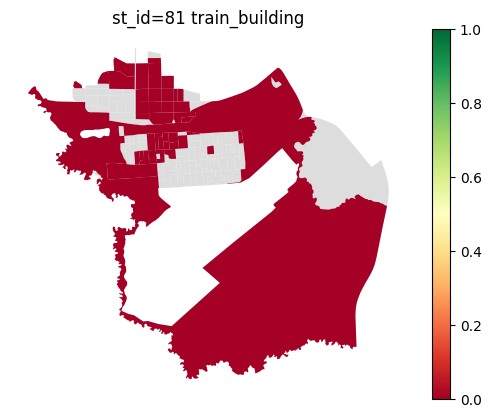

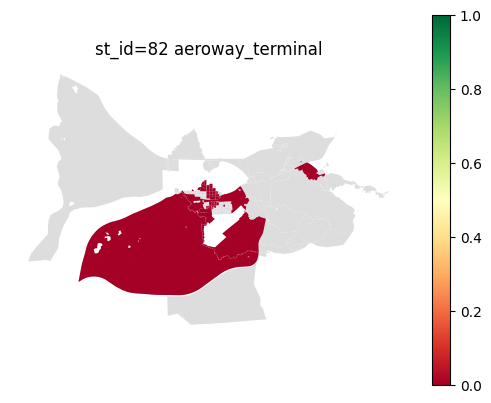

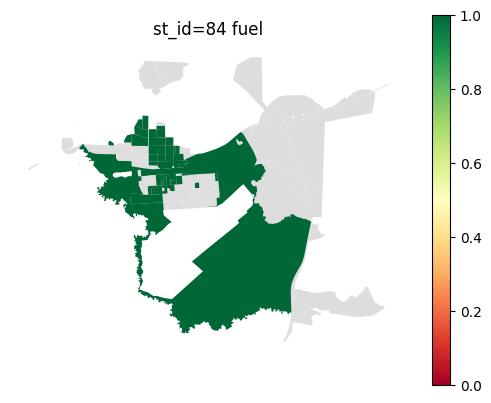

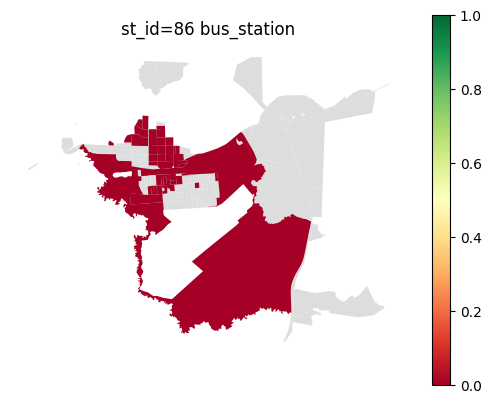

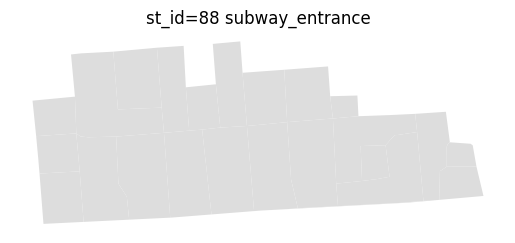

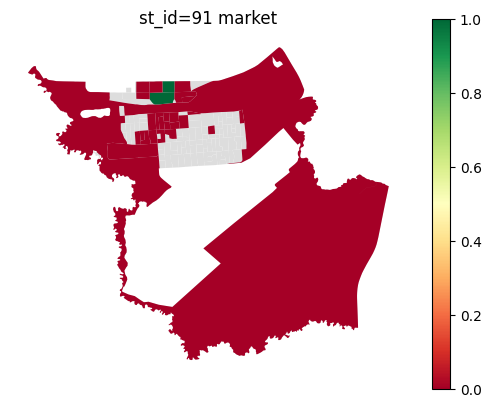

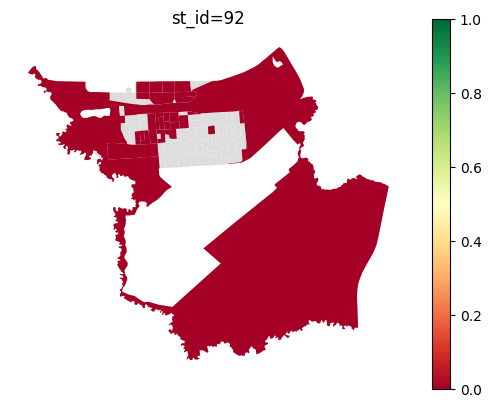

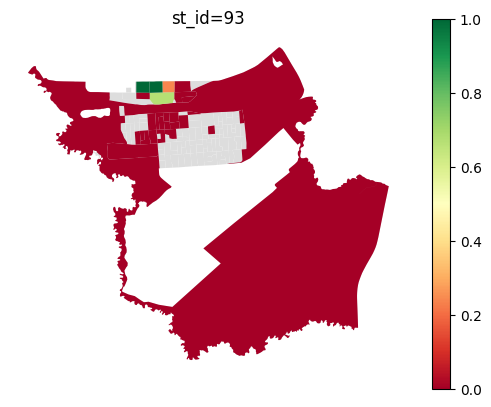

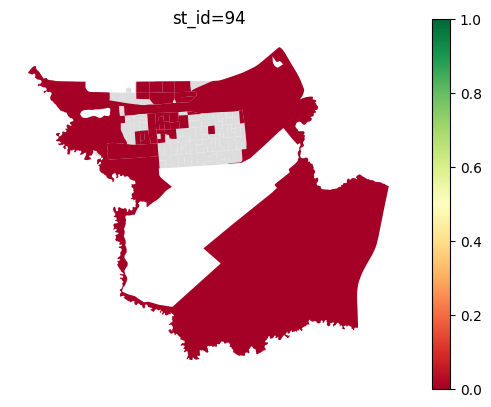

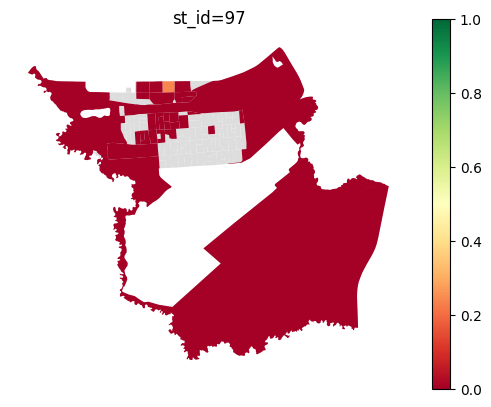

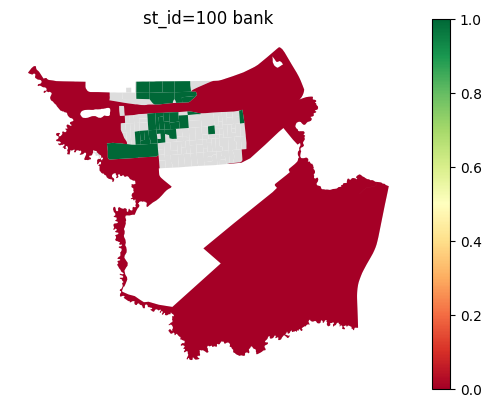

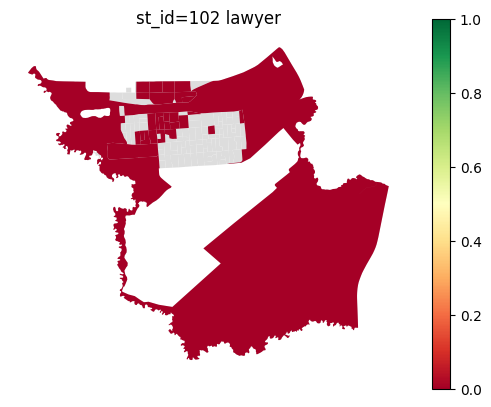

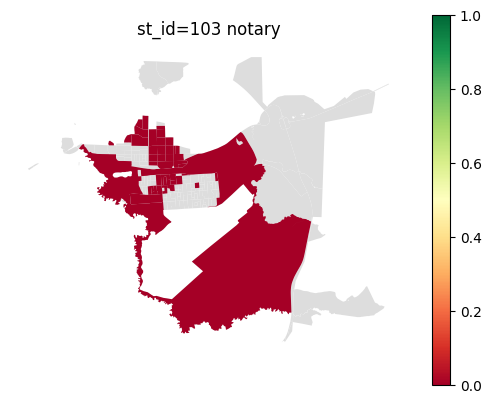

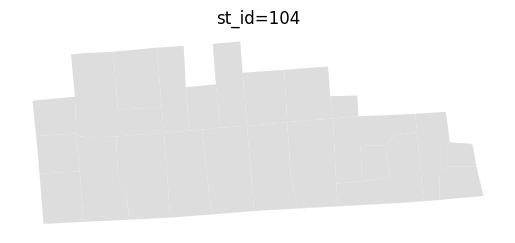

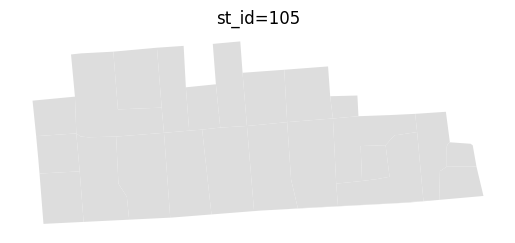

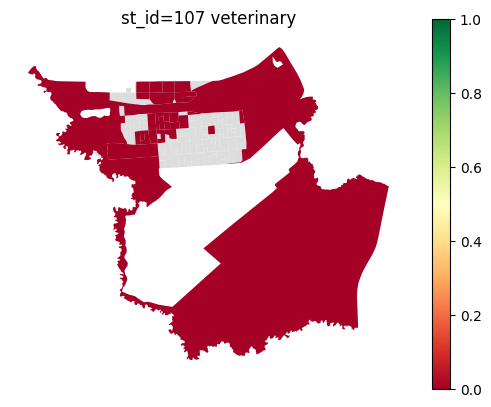

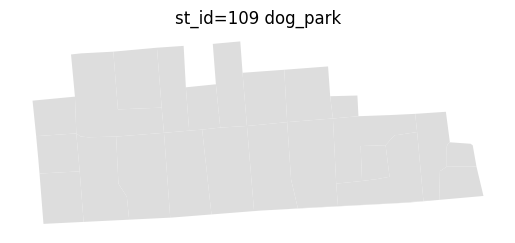

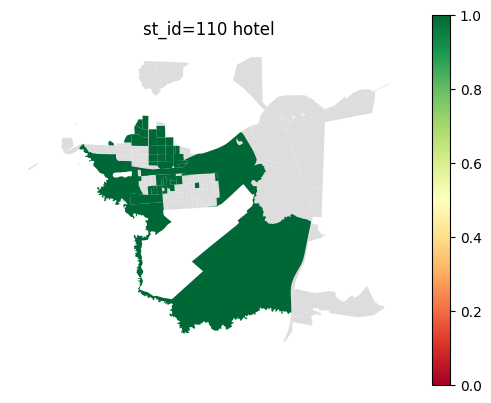

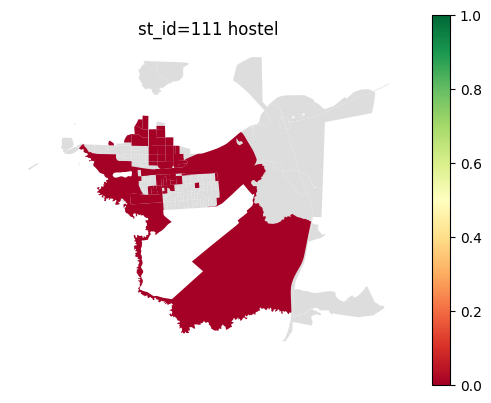

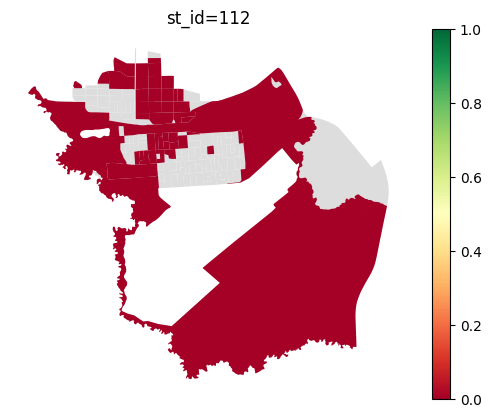

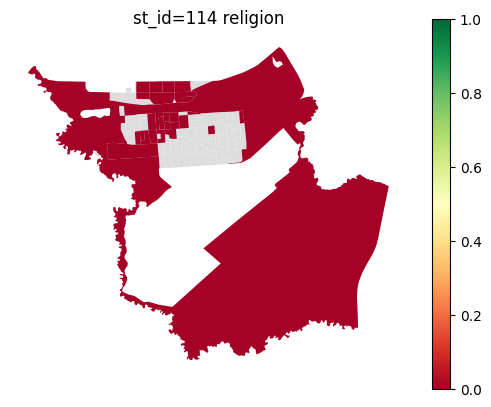

In [21]:
for st_id, prov_gdf in provisions_gdfs.items():
    if prov_gdf is None or len(prov_gdf) == 0:
        continue
    ax = prov_gdf.plot(color='#ddd')
    if not prov_gdf.provision_strong.isna().all():
        prov_gdf.plot(ax=ax, column='provision_strong', legend=True, vmin=0, vmax=1, cmap='RdYlGn')
    ax.set_axis_off()
    title = f'st_id={st_id}'
    bn_name = service_types_df.loc[st_id, 'blocksnet']
    if bn_name is not None:
        title += ' ' + bn_name
    ax.set_title(title) 